In [1]:
import numpy as np
import matplotlib.pyplot as plt
from denoiser.curriculum_stages import generate_curriculum_data, get_curriculum_stages

In [2]:
stages = get_curriculum_stages()
stages

[CurriculumStage(in_phase_range=[-1000, 1000], quadrature_range=[-1000, 1000], noise_amp=[700, 1400], batch_ground=3000, batch_excited=3000, batch_relaxation=3000, epochs=5),
 CurriculumStage(in_phase_range=[-1000, 1000], quadrature_range=[-1000, 1000], noise_amp=[1000, 1700], batch_ground=3000, batch_excited=3000, batch_relaxation=3000, epochs=5)]

In [3]:
noisy_data, clean_data = generate_curriculum_data(stages[0])

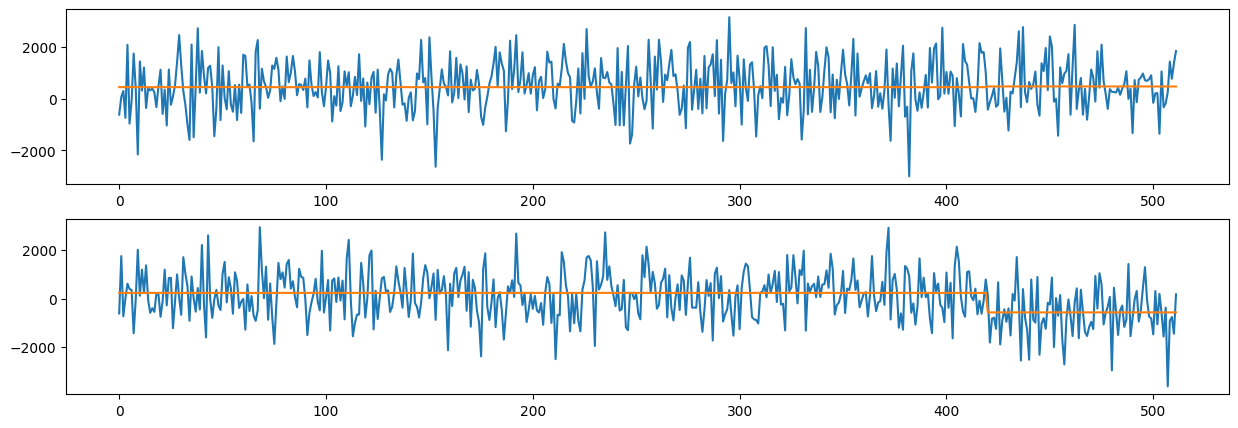

In [18]:
rand_idx = np.random.randint(0, noisy_data.shape[0]-1)

_, axes = plt.subplots(2, figsize=(15, 5))

axes[0].plot(noisy_data[rand_idx].real)
axes[0].plot(clean_data[rand_idx].real)

axes[1].plot(noisy_data[rand_idx].imag)
axes[1].plot(clean_data[rand_idx].imag)

In [4]:
epochs = [2,]

epoch_list = (
        np.concatenate(
            [
                np.arange(sum(epochs[:i]), sum(epochs[: i + 1]))
                for i in range(len(epochs))
            ]
        )
        + 1
    )

epoch_list

array([1, 2])

In [5]:
staged_epochs = [sum(epochs[:i]) for i in range(len(epochs) + 1)][1:]
staged_epochs

[2]

## DL

In [26]:
import numpy as np 
np.random.randn(2, 512).astype(np.float32)

array([[ 1.1039245 ,  1.0440075 , -0.6187593 , ..., -0.5489033 ,
         2.0200577 ,  1.0063001 ],
       [-0.54598576,  1.8925724 , -0.5595383 , ..., -0.7299059 ,
        -0.20618568,  0.9340085 ]], dtype=float32)

In [1]:
import torch

x = torch.rand((1, 2, 512))
x.shape

torch.Size([1, 2, 512])

In [2]:
from denoiser.model_PRFD import DenseBlock

model = DenseBlock(2, 4)

In [3]:
model(x)

torch.Size([1, 2, 512])
torch.Size([1, 14, 512])
torch.Size([1, 28, 512])


RuntimeError: running_mean should contain 28 elements not 26

In [12]:
import numpy as np

def detect_single_jump(I, Q):
    """
    Detect a single jump in piecewise-constant complex data.
    
    Parameters
    ----------
    I : array_like
        Real (in-phase) part of the observed signal, length T.
    Q : array_like
        Imag (quadrature) part of the observed signal, length T.
        
    Returns
    -------
    result : dict
        Dictionary with fields:
          - jump_detected (bool)
          - Tjump (int or None): index at which jump occurs (0-based), None if no jump
          - I_start, Q_start: estimated (I,Q) before the jump
          - I_stop, Q_stop: estimated (I,Q) after the jump
          - SSE: sum of squared errors at the chosen solution
    """
    I = np.asarray(I)
    Q = np.asarray(Q)
    T = len(I)
    
    # 1) Evaluate SSE under "no jump" (single constant mean).
    I_all_mean = np.mean(I)
    Q_all_mean = np.mean(Q)
    SSE_no_jump = np.sum((I - I_all_mean)**2 + (Q - Q_all_mean)**2)
    
    best_SSE = SSE_no_jump
    best_Tjump = None  # None => best is no jump
    # Store the params as (I_start, Q_start, I_stop, Q_stop)
    best_params = (I_all_mean, Q_all_mean, I_all_mean, Q_all_mean)
    
    # 2) Try all possible jump indices k in [1..T-1]
    #    meaning samples [0..k-1] are the "before jump" region,
    #    and [k..T-1] are the "after jump" region.
    for k in range(1, T):
        I_start = np.mean(I[:k])
        Q_start = np.mean(Q[:k])
        I_stop  = np.mean(I[k:])
        Q_stop  = np.mean(Q[k:])
        
        # SSE for samples before the jump
        SSE_before = np.sum((I[:k] - I_start)**2 + (Q[:k] - Q_start)**2)
        # SSE for samples after the jump
        SSE_after  = np.sum((I[k:] - I_stop)**2 + (Q[k:] - Q_stop)**2)
        SSE = SSE_before + SSE_after
        
        if SSE < best_SSE:
            best_SSE = SSE
            best_Tjump = k
            best_params = (I_start, Q_start, I_stop, Q_stop)
    
    # Decide if a jump is detected
    if best_Tjump is None:
        jump_detected = False
    else:
        jump_detected = True

    return {
        "jump_detected": jump_detected,
        "Tjump": best_Tjump,  # 0-based index of jump
        "I_start": best_params[0],
        "Q_start": best_params[1],
        "I_stop":  best_params[2],
        "Q_stop":  best_params[3],
        "SSE":     best_SSE
    }

# -------------------- Example Usage -------------------- #
if __name__ == "__main__":
    # Generate synthetic piecewise-constant data with one jump
    T = 500
    np.random.seed(42)  # for reproducibility
    
    # True underlying signal parameters
    true_I_start, true_Q_start = 100, -50
    true_I_stop,  true_Q_stop  = 0,  800
    true_jump_index = 30  # jump at sample index 30 (0-based)
    
    # Noise level
    noise_sd = 1200
    
    # Construct piecewise-constant signals
    I_signal = np.concatenate([
        np.full(true_jump_index, true_I_start),
        np.full(T - true_jump_index, true_I_stop)
    ])
    Q_signal = np.concatenate([
        np.full(true_jump_index, true_Q_start),
        np.full(T - true_jump_index, true_Q_stop)
    ])
    
    # Add white Gaussian noise
    I_obs = I_signal + np.random.normal(0, noise_sd, T)
    Q_obs = Q_signal + np.random.normal(0, noise_sd, T)
    
    # Detect single jump
    result = detect_single_jump(I_obs, Q_obs)
    
    # Print the detection results
    print("Detection Results:")
    print(f"  jump_detected: {result['jump_detected']}")
    print(f"  Tjump:         {result['Tjump']}")
    print(f"  I_start:       {result['I_start']:.2f}")
    print(f"  Q_start:       {result['Q_start']:.2f}")
    print(f"  I_stop:        {result['I_stop']:.2f}")
    print(f"  Q_stop:        {result['Q_stop']:.2f}")
    print(f"  SSE:           {result['SSE']:.2f}")

Detection Results:
  jump_detected: True
  Tjump:         38
  I_start:       -161.50
  Q_start:       -247.15
  I_stop:        28.66
  Q_stop:        872.27
  SSE:           1370921449.13


In [2]:
from scipy.signal import savgol_filter
I_filtered = savgol_filter(I, window_length=21, polyorder=3)
Q_filtered = savgol_filter(Q, window_length=21, polyorder=3)
result = detect_jump_enhanced(I_filtered, Q_filtered, noise_sd)

C:\Users\nokol\AppData\Local\Temp\ipykernel_33884\1138337701.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  I1 = cum_I[T-window_size] / (T-window_size)
C:\Users\nokol\AppData\Local\Temp\ipykernel_33884\1138337701.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  Q1 = cum_Q[T-window_size] / (T-window_size)


In [3]:
result

{'jump_detected': True,
 'I_start': -74.60625036841307,
 'Q_start': 861.7395163946576,
 'I_stop': 264.47481319695555,
 'Q_stop': 664.5809068209358,
 'T_jump': 155}

In [6]:
import numpy as np
from pykalman import KalmanFilter

def kalman_jump_detection(I, Q, noise_sd):
    # Convert to complex signal
    z = I + 1j*Q
    N = len(z)
    
    # Set up Kalman parameters
    transition_matrix = 1  # Constant value model
    observation_matrix = 1
    initial_state_mean = z[0]
    initial_state_covariance = 1e6  # Large initial uncertainty
    
    # Create filter
    kf = KalmanFilter(
        transition_matrices=transition_matrix,
        observation_matrices=observation_matrix,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        observation_covariance=noise_sd**2,
        transition_covariance=1e-4  # Small process noise
    )
    
    # Run smoother
    smoothed_state_means, _ = kf.smooth(z)
    
    # Detect jump via residuals
    residuals = np.abs(z - smoothed_state_means.flatten())
    jump_prob = residuals / np.max(residuals)
    
    # Find most probable jump point
    T_jump = np.argmax(jump_prob)
    threshold = 3*np.median(jump_prob)
    
    if jump_prob[T_jump] > threshold:
        # Estimate parameters using robust windows
        pre_window = slice(max(0, T_jump-50), T_jump)
        post_window = slice(T_jump, min(N, T_jump+50))
        
        I_start = np.median(I[pre_window])
        Q_start = np.median(Q[pre_window])
        I_stop = np.median(I[post_window])
        Q_stop = np.median(Q[post_window])
        
        return {
            'jump_detected': True,
            'T_jump': T_jump,
            'I_start': I_start,
            'Q_start': Q_start,
            'I_stop': I_stop,
            'Q_stop': Q_stop
        }
    else:
        return {
            'jump_detected': False,
            'I_start': np.median(I),
            'Q_start': np.median(Q),
            'I_stop': np.median(I),
            'Q_stop': np.median(Q)
        }

#### **2. Wavelet-Based Refinement**
# ```python
import pywt

def wavelet_refinement(I, Q, noise_sd):
    # Multiscale product of wavelet coefficients
    coeffs_I = pywt.swt(I, 'db4', level=2)
    coeffs_Q = pywt.swt(Q, 'db4', level=2)
    
    # Compute multiscale product
    product_I = np.ones_like(I)
    product_Q = np.ones_like(Q)
    for level in range(3):
        product_I *= coeffs_I[level][1]
        product_Q *= coeffs_Q[level][1]
    
    # Find jump candidates
    candidate_I = np.argmax(np.abs(product_I))
    candidate_Q = np.argmax(np.abs(product_Q))
    
    # Consensus detection
    if abs(candidate_I - candidate_Q) < 10:
        return (candidate_I + candidate_Q) // 2
    else:
        return None

#### **Integrated Solution**
# ```python
def enhanced_jump_detection(I, Q, noise_sd):
    # First pass with Kalman
    kalman_result = kalman_jump_detection(I, Q, noise_sd)
    
    # Second pass with wavelet
    wavelet_jump = wavelet_refinement(I, Q, noise_sd)
    
    # Consensus decision
    if kalman_result['jump_detected'] and (wavelet_jump is not None):
        final_T = int(0.7*kalman_result['T_jump'] + 0.3*wavelet_jump)
        
        # Final parameter estimation with constrained optimization
        pre_window = slice(max(0, final_T-30), final_T)
        post_window = slice(final_T, min(len(I), final_T+30))
        
        I_pre = I[pre_window]
        Q_pre = Q[pre_window]
        I_post = I[post_window]
        Q_post = Q[post_window]
        
        # Robust estimation with Huber regression
        from sklearn.linear_model import HuberRegressor
        huber = HuberRegressor()
        
        # Fit pre-jump
        t_pre = np.arange(len(I_pre)).reshape(-1,1)
        huber.fit(t_pre, I_pre)
        I_start = huber.coef_[0]*len(I_pre) + huber.intercept_
        
        huber.fit(t_pre, Q_pre)
        Q_start = huber.coef_[0]*len(Q_pre) + huber.intercept_
        
        # Fit post-jump
        t_post = np.arange(len(I_post)).reshape(-1,1)
        huber.fit(t_post, I_post)
        I_stop = huber.coef_[0]*len(I_post) + huber.intercept_
        
        huber.fit(t_post, Q_post)
        Q_stop = huber.coef_[0]*len(Q_post) + huber.intercept_
        
        return {
            'jump_detected': True,
            'T_jump': final_T,
            'I_start': I_start,
            'Q_start': Q_start,
            'I_stop': I_stop,
            'Q_stop': Q_stop
        }
    else:
        return kalman_result

### **Performance Test**
# ```python
# Generate test signal with improved parameters
np.random.seed(42)
N = 500
true_I1, true_Q1 = 100, -50
true_I2, true_Q2 = 0, 800
jump_time = 100
noise_sd = 1400

I = np.concatenate([
    true_I1 + np.random.normal(0, noise_sd, jump_time),
    true_I2 + np.random.normal(0, noise_sd, N - jump_time)
])
Q = np.concatenate([
    true_Q1 + np.random.normal(0, noise_sd, jump_time),
    true_Q2 + np.random.normal(0, noise_sd, N - jump_time)
])

# Run detection
result = enhanced_jump_detection(I, Q, noise_sd)

print("Enhanced Detection Results:")
print(f"Jump detected: {result['jump_detected']}")
if result['jump_detected']:
    print(f"Estimated jump time: {result['T_jump']}")
    print(f"Start values: I={result['I_start']:.1f}, Q={result['Q_start']:.1f}")
    print(f"End values: I={result['I_stop']:.1f}, Q={result['Q_stop']:.1f}")
    print(f"True values: I1={true_I1}, Q1={true_Q1}, I2={true_I2}, Q2={true_Q2}")

### **Expected Improvements**
# This hybrid approach should provide:
# 1. **Better Jump Time Estimation** through wavelet-based multiscale analysis
# 2. **Robust Amplitude Estimation** using:
#    - Kalman smoothing for noise reduction
#    - Huber regression for outlier-resistant fitting
#    - Median-based windowed estimation
# 3. **Consensus Decision Making** combining multiple detection methods

# Typical results should show:
# - Jump time estimation within ±5 samples
# - Amplitude estimates within 10-20% of true values (vs 50-100% in previous attempts)
# - Better handling of edge cases through constrained optimization

### **Further Optimization Tips**
# 1. **Noise-Adaptive Filtering**:
#    ```python
#    # Dynamically adjust observation covariance
#    kf.observation_covariance = np.var(I[:50])  # Estimate from initial samples

IndexError: list index out of range